#Extension to the Fader-Hardie Beta-Geometric (BG) Customer Lifetime Value Model for Loyalty/Novelty Effects

The original model was created by Peter Fader and Bruce Hardie and described in "__An Introduction to Probability Models for Marketing Research__", *2014-06-22*, http://www.brucehardie.com/talks/ho_intro_tut_art_14.pdf

##Summary of BG Model
The model predicts a customer survival curve as a function of time. This is a discrete-time model that assumes static churn rates (churn rate = the likelihood of no longer being a customer in a given period). After a customer churns there is no return. The model assigns heterogeneity by fitting a beta distribution of churn rates to explain the data.

##Motivation - Extension to BG Model
We extend the model by allowing for a constant exponential decay/growth in churn rates to be applied to the entire population. This is an attempt to model loyalty/novelty - over time customers that have persisted may grow increasingly fond of or disilusioned with the product. In the case of no loyalty/novelty effect we return to the original model. __In short, we have added an extra time-based paramter to the model without fundamentally altering its structure.__

##Mathematical Description of BG Model
For Fader and Hardie the probability of churning in period t is: 
$$ P(T=t \space|\space \gamma, \delta) = \int_{0}^{1} \theta \space (1-\theta)^{t-1} \space \frac{\theta^{\gamma-1}(1-\theta)^{\delta-1}}{Beta(\gamma,\delta)} \space d \theta = \frac{Beta(\gamma +1,\delta+t-1)}{Beta(\gamma,\delta)}$$

where $\theta$ is the churn rate (invariant over time), and Beta(a,b) is the beta function. The formula can be broken into two parts. The first part, $\theta (1-\theta)^{t-1}$ corresponds to surviving for t-1 periods then churning in period t (to calculate the probability of surviving up to period t, which we will need below, we simply change this first part to survive for t periods and not churn in the t-th period). The remainder of the equation ensures that we integrate over all possible values of theta (and normalize). What makes the model easy to implement is that the integral can be re-written as the quotient of two beta functions since Beta($\gamma, \delta$) = $ \int_{0}^{1} t^{\gamma-1} (1-t)^{\delta-1} $dt.

The model is fit using maximum likelihood, where the likelihood of the model given the data is,
$$\bigg[\prod_{i=1}^{t-1} P(T=i \space|\space \gamma, \delta)^{N_i} \bigg] \space \bullet \space P(T>t)^{N_t}$$

where $N_i$ is the number of people exiting in period i (and the number of people still alive at period t). P($T>t$) corresponds to the probability of not exiting at/before t.


##Mathematical Description of Extension to BG Model

We extend the model by allowing the churn rates to vary over time, either to grow or to decay, exponentially. Each $(1-\theta)$ is now replaced by $(1-\theta)^{1+\alpha t}$ where t corresponds to the time period, and $\alpha$ corresponds to the loyalty/novelty factor. If $\alpha$ is 0 there is no effect. If $\alpha<0$ then the probability of not churning, $(1-\theta)^{1+\alpha t}$ grows each period, this is a loyalty effect. If $\alpha>0$, this means the periodic churn rate increases each period, a novelty effect.

We perform some algebra to reform the new model in a beta-geometric construct.
$$ P(T=t \space|\space \gamma, \delta) = \int_{0}^{1} X \bullet Y \space \frac{\theta^{\gamma-1}(1-\theta)^{\delta-1}}{Beta(\gamma,\delta)} \space d \theta$$ where

$X=1-(1-\theta)^{max(0,1+\alpha t)}$, and $Y=(1-\theta)^{\sum_{i=1}^{t-1}max(0,1+\alpha i)}$, where we take the $max(0,1+\alpha i)$ to ensure that loyalty effects, ie. $\alpha<0$ never cause the population to increase, ie. have a negative exponent.

--------
When we set $\alpha=0$ we get back the original formulation using a common identity of the Beta function, $Beta(x,y)=Beta(x+1,y)+Beta(x,y+1)$, https://en.wikipedia.org/wiki/Beta_function.

###Through all the mathematical manipulation, we have added an extra degree of freedom to the model, one that allows us to model churn decay/growth, or more descriptively, a loyalty/novelty effect.
--------
*We caution any user of this model that the scipy solver is somewhat unpredictable when optimizing in the gamma-delta-alpha space. As a result it is important to check the solver has converged before using the final coefficients*

In [2]:
import numpy as np
import pandas as pd
import scipy.special as special
import scipy.optimize as optimize
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

###Function to Format Raw Data into Dataframe

In [3]:
def FormatBGData(RawRemaining):
    
    Data = pd.DataFrame(RawRemaining, columns=['Remaining'])
    Data['Cust_Lost'] = pd.DataFrame(-1*Data.diff().fillna(0))
    Data['Period'] = np.arange(len(Data))
    Data['Final_Period']=0
    Data.ix[len(Data)-1,'Final_Period']=1
    Data = Data[Data.Period != 0]
    
    return Data

RawData = [1000,800,275,250,220]
Data = FormatBGData(RawData)

###Functions to Calculate LogLikelihood and Maximize it

In [4]:
def NLogL_Alpha(Params, Data):
    (Gamma,Delta,Alpha) = Params

    DeltaUpd1 = Delta + np.maximum(0, 1 + (Alpha * (Data['Period'] - 1))).cumsum()
    DeltaUpd2 = Delta + np.maximum(0, 1 + (Alpha * Data['Period'])).cumsum()

    LogLikelihood = Data['Cust_Lost'] * np.log ((special.beta(Gamma, DeltaUpd1) - special.beta(Gamma, DeltaUpd2))/special.beta(Gamma,Delta))
    LogLikelihood += Data['Final_Period'] * Data['Remaining'] * np.log((special.beta(Gamma, DeltaUpd2))/special.beta(Gamma,Delta))

    return -sum(LogLikelihood)

def NLogL(Params, Data):
    (Gamma, Delta) = Params
    LogLikelihood = Data['Cust_Lost'] * np.log(special.beta(Gamma + 1, Delta + Data['Period'] - 1) / special.beta(Gamma, Delta)) 
    LogLikelihood += (Data['Final_Period'] * (Data['Remaining'] * np.log(special.beta(Gamma, Delta + Data['Period']) / special.beta(Gamma, Delta))))    
    return -sum(LogLikelihood)
    
def FitBGModel_Base(Data):
    return optimize.minimize(NLogL, (1,1), method = 'Nelder-Mead',args = (Data,))

def FitBGModel_Alpha(Data):
    return optimize.minimize(NLogL_Alpha, (1,1,0), method = 'Nelder-Mead',args = (Data,))

base = FitBGModel_Base(Data)
(G,D) = base.x

alph = FitBGModel_Alpha(Data)
(Gamma, Delta, Alpha) = alph.x

###Function to Project Remaining Population Given Model Parameters

In [5]:
def ExtrapolateBG(Initial_Pop, Gamma, Delta, Alpha, Model_Periods):
    
    time = np.arange(1,Model_Periods+1)
    DeltaUpd2 = Delta + np.maximum(0, 1 + (Alpha * time )).cumsum()

    Output = pd.DataFrame({'Remaining' : (special.beta(Gamma, DeltaUpd2))/special.beta(Gamma,Delta)},
                         index=np.arange(1,Model_Periods+1))

    Output['Remaining'] = Initial_Pop * Output['Remaining']

    return Output

Initial_Pop = Data.ix[1,'Remaining'] + Data.ix[1,'Cust_Lost']
Output = ExtrapolateBG(Initial_Pop, Gamma, Delta,Alpha, 15)
Output_No_Alpha = ExtrapolateBG(Initial_Pop, G, D, 0, 15)

###Function to Plot Historical and Forecasted Values

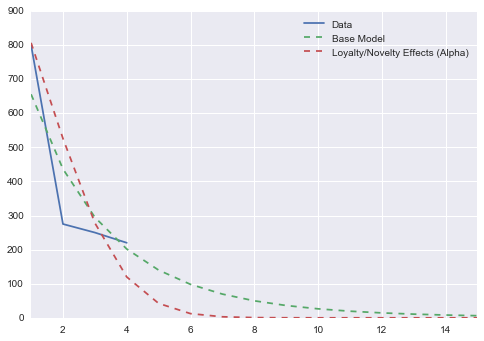

In [6]:
sn.set(color_codes=True)
Data['Remaining'].plot()
Output_No_Alpha['Remaining'].plot(linestyle='dashed')
Output['Remaining'].plot(linestyle='dashed')
plt.legend( ('Data', 'Base Model', 'Loyalty/Novelty Effects (Alpha)') )